In [69]:
from numpy import loadtxt
import numpy as np
import pandas as pd
from sklearn import svm, grid_search
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectPercentile, f_classif
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 20
#import plotly.plotly as py
#from plotly.graph_objs import *

Introduction
Wearable sensors have become increasingly popular over the last few years with the success of smartphones, fitness trackers, and smart watches. All of these devices create a large amount of data that is ideal for machine learning. Two early examples are the FitBit and Jawbone’s up band, both of which analyze sensor input to determine how many steps the user has taken, a metric which is helpful for measuring physical activity. There is no reason to stop there: With all of this data available it is also possible to extract more information. For example, fitness trackers coming out now can also analyze your sleep.

In that spirit, I’m going to show here that it is pretty straightforward to make an algorithm that can differentiate between 6 different states.

    Walking
    Walking Upstairs
    Walking Downstairs
    Sitting
    Standing
    Laying


Load packages and source data
For this example, I used one of the datasets available from the UCI Machine Learning Repository. For this data set 30 subjects were recorded performing activities of daily living (ADL) while carrying a waist-mounted smartphone (Samsung Galaxy II) with embedded inertial sensors. A testing dataset and training dataset are provided. The dataset has 561 features which were created from the sensor data: XYZ acceleration, etc.

In [2]:
data_test = loadtxt("./UCI_HAR_Dataset/test/X_test.txt")
label_test=loadtxt("./UCI_HAR_Dataset/test/y_test.txt")
data_train = loadtxt("./UCI_HAR_Dataset/train/X_train.txt")
label_train = loadtxt("./UCI_HAR_Dataset/train/y_train.txt")

In [30]:
features = np.genfromtxt("./UCI_HAR_Dataset/features.txt",dtype=None,usecols=[1])

In [34]:
test1 = pd.DataFrame(data_train, columns=features)

In [41]:
data_test.shape[-1]

561

Feature selection
Given that this data set has training and testing data with labels, it makes sense to do supervised machine learning. We have over 500 potential features to use, which is a lot. Let’s see if we can get by with fewer features. To do that, we will use SK-learn’s SelectKBest to keep the top 20 percent of the features, and then transform the data.

In [53]:
selector = SelectPercentile(f_classif, 2)
selector.fit(data_train, label_train)
data_train_transformed = selector.transform(data_train)
data_test_transformed = selector.transform(data_test)

In [54]:
data_train_transformed.shape

(7352, 12)

In [60]:
#print 'Scores of these features:', selector.scores_
print '***Features sorted by score:', [features[i] for i in np.argsort(selector.scores_)[::-1]][:12]

***Features sorted by score: ['fBodyAccJerk-entropy()-X', 'tGravityAcc-mean()-X', 'tGravityAcc-min()-X', 'fBodyAccJerk-entropy()-Y', 'tGravityAcc-max()-X', 'tGravityAcc-energy()-X', 'fBodyBodyAccJerkMag-entropy()', 'tBodyAccJerkMag-entropy()', 'fBodyAcc-entropy()-X', 'tBodyAccJerk-entropy()-X', 'tBodyAcc-max()-X', 'fBodyAccJerk-entropy()-Z']


In [61]:
features_transformed = [features[i] for i in np.argsort(selector.scores_)[::-1]][:12]

In [63]:
data_train_transformed_pandas = pd.DataFrame(data_train_transformed, columns=features_transformed)

['fBodyAccJerk-entropy()-X', 'tGravityAcc-mean()-X', 'tGravityAcc-min()-X', 'fBodyAccJerk-entropy()-Y', 'tGravityAcc-max()-X', 'tGravityAcc-energy()-X', 'fBodyBodyAccJerkMag-entropy()', 'tBodyAccJerkMag-entropy()', 'fBodyAcc-entropy()-X', 'tBodyAccJerk-entropy()-X', 'tBodyAcc-max()-X', 'fBodyAccJerk-entropy()-Z']
       fBodyAccJerk-entropy()-X  tGravityAcc-mean()-X  tGravityAcc-min()-X  \
count               7352.000000           7352.000000          7352.000000   
mean                  -0.468604              0.664122             0.604165   
std                    0.544547              0.516763             0.510073   
min                   -1.000000             -1.000000            -1.000000   
25%                   -0.936219              0.804863             0.743386   
50%                   -0.881637              0.919513             0.857335   
75%                   -0.017129              0.953065             0.886765   
max                    1.000000              0.991549        

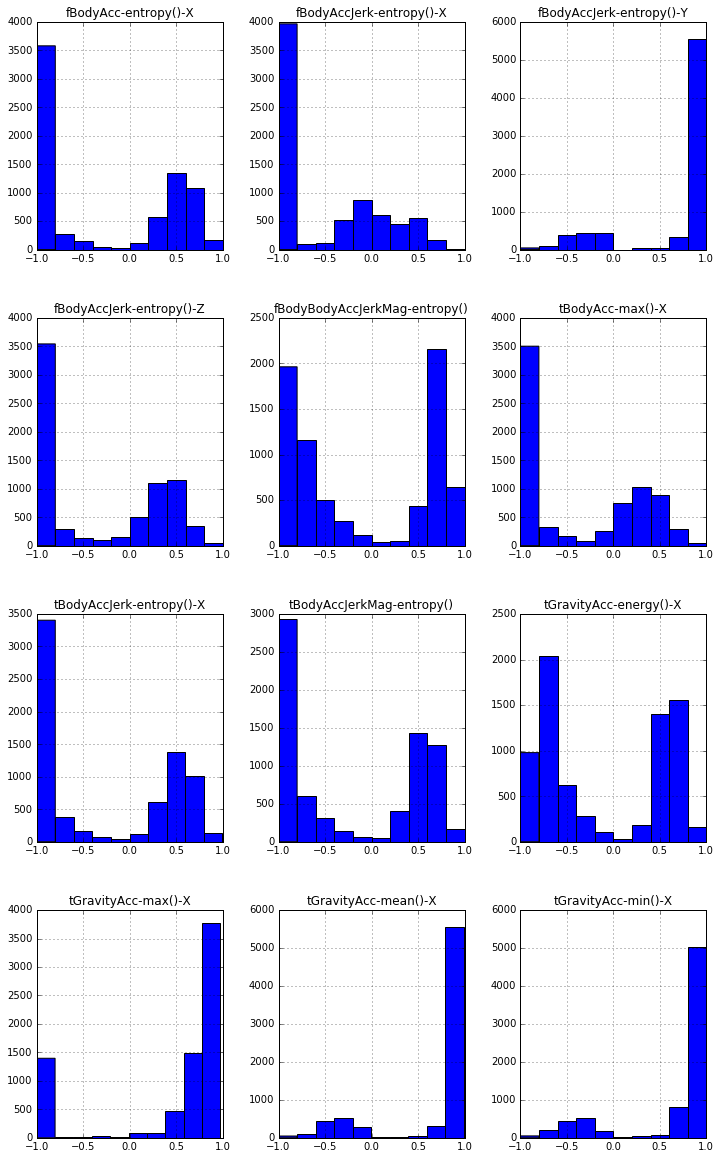

In [72]:
print features_transformed
print(data_train_transformed_pandas.describe())
data_train_transformed_pandas.hist();

Machine learning
At this point you need to decide which algorithm you want to use. I tried a few of them and got the best results using a Support Vector Machine (SVM). SVMs attempt to determine the decision boundary between two classes that is as far away from the data of both classes as possible. In general they work pretty well.

Let’s try some parameters and see how good our results are.

In [55]:
clf = svm.SVC(kernel="rbf", C=1)
clf.fit(data_train_transformed, label_train)
pred=clf.predict(data_test_transformed)
 
print "Accuracy is %.4f and the f1-score is %.4f " % (
    accuracy_score(pred, label_test), f1_score(label_test, pred))

Accuracy is 0.7927 and the f1-score is 0.7772 


/home/kswamy/anaconda2/envs/dato-env/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


Optimization
That’s not too bad, but I think we can still optimize our results some more. We could change the parameters manually, or we can automate the task using a grid search. This is a handy module that allows you to do a parameter sweep. Below, I set up a sweep using two different kernels and various penalty term values (C) to see if we can raise our accuracy.

In [56]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000, 10000, 100000]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(data_train_transformed, label_train)
pred=clf.predict(data_test_transformed)
 
print "Accuracy is %.4f and the f1-score is %.4f " % (
    accuracy_score(pred, label_test), f1_score(label_test, pred))

Accuracy is 0.8025 and the f1-score is 0.7877 


/home/kswamy/anaconda2/envs/dato-env/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [57]:
clf.best_params_

{'C': 1000, 'kernel': 'linear'}

In [ ]:
trace1 = Scatter(
     x=X,
     marker=Marker(
        color='rgba(159, 197, 232, 0.2)',
        size=8,
        symbol='square'
    ),
    mode='markers',
    name='Walking',
    uid='04a053',
    visible=True,
    xaxis='x3',
    yaxis='y3'
)
trace2 = Scatter(
    x=X,
    marker=Marker(
        color='rgba(0, 0, 0, 0.2)',
        size=8
    ),
    mode='markers',
    name='Standing',
    uid='1b4961',
    visible=True,
    xaxis='x2',
    yaxis='y2'
)
trace3 = Scatter(
     x=X,y=Y
     marker=Marker(
        color='rgba(255, 0, 0, 0.2)',
        size=8,
        symbol='cross'
    ),
    mode='markers',
    name='Laying',
    uid='e93851'
)
data = Data([trace1, trace2, trace3])
layout = Layout(
    autosize=True,
    height=504,
    legend=Legend(
        x=0.9806451612903226,
        y=0.9969135802469136,
        bgcolor='rgb(255, 255, 255)',
        bordercolor='rgb(0, 0, 0)',
        borderwidth=1,
        xanchor='auto',
        yanchor='auto'
    ),
    showlegend=True,
    title='$\text{Machine Learning Results}$',
    titlefont=dict(
        size=20
    ),
    width=625,
    xaxis=XAxis(
        anchor='y',
        autorange=False,
        domain=[0, 1],
        gridcolor='rgb(238, 238, 238)',
        gridwidth=1,
        range=[-0.3, 0.15522263583567814],
        showline=True,
        title='$\text{Z Acceleration } (\mu)$',
        type='linear',
        zeroline=False
    ),
    xaxis2=XAxis(
        anchor='y2',
        autorange=False,
        domain=[0, 1],
        gridcolor='rgb(238, 238, 238)',
        gridwidth=1,
        range=[-0.3, 0.1528153602440619],
        showline=True,
        title='$\text{Z Acceleration } (\mu)$',
        type='linear',
        zeroline=False
    ),
    xaxis3=XAxis(
        anchor='y3',
        autorange=False,
        domain=[0, 1],
        gridcolor='rgb(238, 238, 238)',
        gridwidth=1,
        range=[-0.3, 0.1528153602440619],
        showline=True,
        title='$\text{Z Acceleration } (\mu)$',
        type='linear',
        zeroline=False
    ),
    yaxis=YAxis(
        anchor='x',
        autorange=False,
        domain=[0, 0.2333333333333333],
        gridcolor='rgb(238, 238, 238)',
        gridwidth=1,
        range=[-1.1470567934353162, 0.22976500738905675],
        showline=True,
        title='$\text{Z Acceleration } (\sigma)$',
        type='linear',
        zeroline=False
    ),
    yaxis2=YAxis(
        anchor='x2',
        autorange=False,
        domain=[0.3833333333333333, 0.6166666666666666],
        gridcolor='rgb(238, 238, 238)',
        gridwidth=1,
        range=[-1.1470567934353162, 0.22976500738905675],
        showline=True,
        title='$\text{Z Acceleration } (\sigma)$',
        type='linear',
        zeroline=False
    ),
    yaxis3=YAxis(
        anchor='x3',
        autorange=False,
        domain=[0.7666666666666666, 0.9999999999999999],
        gridcolor='rgb(238, 238, 238)',
        gridwidth=1,
        range=[-1.1470567934353162, 0.22976500738905675],
        showline=True,
        title='$\text{Z Acceleration } (\sigma)$',
        type='linear',
        zeroline=False
    )
)
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig)